<a href="https://colab.research.google.com/github/rafaelsudbrackzimmermann/-MachineLearning/blob/main/CytologIA_VIT_Training_(1)_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# inicio

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rafaelzimmermann1_cytologia_dataset_path = kagglehub.dataset_download('rafaelzimmermann1/cytologia-dataset')
rafaelzimmermann1_cytologia_aug_1_path = kagglehub.dataset_download('rafaelzimmermann1/cytologia-aug-1')

print('Data source import complete.')


Data source import complete.


In [4]:
rafaelzimmermann1_cytologia_dataset_path

'/root/.cache/kagglehub/datasets/rafaelzimmermann1/cytologia-dataset/versions/5'

In [5]:
# Bibliotecas principais
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer

# Visualização e avaliação
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image


In [6]:
DEBUG = True
# Configuration for model training
FOLDS = 1
EPOCHS = 15
BATCH = 32
VERBOSE = 1

PATH_IMAGES = f'{rafaelzimmermann1_cytologia_dataset_path}/images/dataset_cytologia/'
PATH_IMAGES_AUG = f'{rafaelzimmermann1_cytologia_aug_1_path}/aug_0_5/'
SPEC_SIZE  = (224, 224, 3)
CLASSES = ['PNN', 'MO', 'MM', 'LyB', 'LGL', 'Thromb', 'LLC', 'LAM3', 'EO',
       'LY', 'BA', 'MoB', 'LM', 'LH_lyAct', 'Lysee', 'Er', 'LF', 'LZMG',
       'MBL', 'SS', 'PM', 'B', 'M']
N_CLASSES = len(CLASSES)
TARGETS = CLASSES

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Carregar os dados
train =  pd.read_csv(f"{rafaelzimmermann1_cytologia_dataset_path}/cytologia-data-train.csv")

if DEBUG:
    train = train[:1000].copy()
else:
    train = train.copy()

train

,NAME,x1,y1,x2,y2,class
0,cf7734a2-b.jpg,99,88,266,276,PNN
1,e6a3b579-0.jpg,92,78,272,284,MO
2,60f95776-f.jpg,110,103,251,251,MM
3,0894e581-c.jpg,112,121,248,262,LyB
4,3998a979-3.jpg,94,86,276,281,MO
...,...,...,...,...,...,...
995,cf85b909-a.jpg,105,106,269,269,B
996,c8c5155f-b.jpg,85,86,286,261,PM
997,5fa689e1-6.jpg,122,118,241,265,B
998,d2d3c289-b.jpg,91,85,271,286,MO


In [8]:
from sklearn.preprocessing import LabelEncoder

# Codificar as classes como números inteiros
label_encoder = LabelEncoder()
train['class_enum'] = label_encoder.fit_transform(train['class'])

# Salve o mapeamento para futuras referências
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:", class_mapping)

Class Mapping: {'B': 0, 'BA': 1, 'EO': 2, 'Er': 3, 'LAM3': 4, 'LF': 5, 'LGL': 6, 'LH_lyAct': 7, 'LLC': 8, 'LM': 9, 'LY': 10, 'LZMG': 11, 'LyB': 12, 'Lysee': 13, 'M': 14, 'MBL': 15, 'MM': 16, 'MO': 17, 'MoB': 18, 'PM': 19, 'PNN': 20, 'SS': 21, 'Thromb': 22}


In [9]:
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd

df = pd.DataFrame(train)

# Adicionar contagem ao DataFrame original
df['count'] = df.groupby('NAME')['NAME'].transform('count')

# Obter IDs únicos e suas contagens
image_ids_counts = df[['NAME', 'count']].drop_duplicates()

# Inicializar o StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

# Preparar um DataFrame para mapear cada 'NAME' ao seu 'fold'
fold_df = pd.DataFrame({'NAME': image_ids_counts['NAME'].unique()})

# Aplicar o StratifiedGroupKFold e armazenar os resultados diretamente no DataFrame 'fold_df'
fold_df['fold'] = -1  # Inicializar a coluna 'fold' com -1

display(fold_df)

for fold_number, (train_idx, val_idx) in enumerate(sgkf.split(X=image_ids_counts, y=image_ids_counts['count'], groups=image_ids_counts['NAME'])):
    fold_df.loc[val_idx, 'fold'] = fold_number

# Mapear a coluna 'fold' de volta para o DataFrame original usando merge
df = df.merge(fold_df, on='NAME', how='left')

df['fold'].value_counts()
df

,NAME,fold
0,cf7734a2-b.jpg,-1
1,e6a3b579-0.jpg,-1
2,60f95776-f.jpg,-1
3,0894e581-c.jpg,-1
4,3998a979-3.jpg,-1
...,...,...
993,cf85b909-a.jpg,-1
994,c8c5155f-b.jpg,-1
995,5fa689e1-6.jpg,-1
996,d2d3c289-b.jpg,-1


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


,NAME,x1,y1,x2,y2,class,class_enum,count,fold
0,cf7734a2-b.jpg,99,88,266,276,PNN,20,1,4
1,e6a3b579-0.jpg,92,78,272,284,MO,17,1,3
2,60f95776-f.jpg,110,103,251,251,MM,16,1,5
3,0894e581-c.jpg,112,121,248,262,LyB,12,1,2
4,3998a979-3.jpg,94,86,276,281,MO,17,1,4
...,...,...,...,...,...,...,...,...,...
995,cf85b909-a.jpg,105,106,269,269,B,0,1,5
996,c8c5155f-b.jpg,85,86,286,261,PM,19,1,1
997,5fa689e1-6.jpg,122,118,241,265,B,0,1,1
998,d2d3c289-b.jpg,91,85,271,286,MO,17,1,9


# dataset

In [10]:
!pip install datasets
!pip install --upgrade evaluate
!pip install accelerate -U

In [11]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [12]:
from datasets import Dataset
hf_dataset = Dataset.from_pandas(df)

# Criar conjunto de treino (todos os folds, exceto o 0 e o 1)
train_dataset = hf_dataset.filter(lambda x: x['fold'] not in [0, 1, 2])

# Criar conjunto de validação (apenas fold 0)
val_dataset = hf_dataset.filter(lambda x: x['fold'] == 0)

# Criar conjunto de teste (apenas fold 1)
test_dataset = hf_dataset.filter(lambda x: x['fold'] == 1)

display(train_dataset)
display(val_dataset)
display(test_dataset)

from PIL import Image
import numpy as np
import random
import os

def process_image_train(example):
    name = example['NAME']
    x1, y1, x2, y2 = example["x1"], example["y1"], example["x2"], example["y2"]

    rand_aug = random.randint(1, 5)
    base_name = os.path.splitext(name)[0]
    id_suffix = f"{base_name}_{x1}_{y1}_{x2}_{y2}_aug{rand_aug}.jpg"
    file_path = os.path.join(PATH_IMAGES_AUG, id_suffix)
    img = Image.open(file_path).convert('RGB')

    # Redimensionar se necessário para SPEC_SIZE
    if img.size != (SPEC_SIZE[0], SPEC_SIZE[1]):
        img = img.resize((SPEC_SIZE[0], SPEC_SIZE[1]))

    # Converter para array, normalizar e transpor para (C, H, W)
    img_array = np.array(img, dtype=np.float32) / 255.0
    # img_array = np.transpose(img_array, (2, 0, 1))  # (H, W, C) -> (C, H, W)

    return {
        "pixel_values": img_array,
        "labels": example["class_enum"]
    }

def process_image_val(example):
    name = example['NAME']
    x1, y1, x2, y2 = example["x1"], example["y1"], example["x2"], example["y2"]

    file_path = os.path.join(PATH_IMAGES, name)
    img = Image.open(file_path).convert('RGB')
    img = img.crop((x1, y1, x2, y2))
    img = img.resize((SPEC_SIZE[0], SPEC_SIZE[1]))

    # Converter para array, normalizar e transpor para (C, H, W)
    img_array = np.array(img, dtype=np.float32) / 255.0
    # img_array = np.transpose(img_array, (2, 0, 1))  # (H, W, C) -> (C, H, W)

    return {
        "pixel_values": img_array,
        "labels": example["class_enum"]
    }


# Exemplo: se hf_dataset for de treino
#with_transform
train_dataset = train_dataset.map(process_image_train)
val_dataset = val_dataset.map(process_image_val)
display(train_dataset)
display(val_dataset)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['NAME', 'x1', 'y1', 'x2', 'y2', 'class', 'class_enum', 'count', 'fold'],
    num_rows: 700
})

Dataset({
    features: ['NAME', 'x1', 'y1', 'x2', 'y2', 'class', 'class_enum', 'count', 'fold'],
    num_rows: 100
})

Dataset({
    features: ['NAME', 'x1', 'y1', 'x2', 'y2', 'class', 'class_enum', 'count', 'fold'],
    num_rows: 100
})

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['NAME', 'x1', 'y1', 'x2', 'y2', 'class', 'class_enum', 'count', 'fold', 'pixel_values', 'labels'],
    num_rows: 700
})

Dataset({
    features: ['NAME', 'x1', 'y1', 'x2', 'y2', 'class', 'class_enum', 'count', 'fold', 'pixel_values', 'labels'],
    num_rows: 100
})

In [23]:
# import torch

# def collate_fn(batch):
#     pixel_values = torch.stack([torch.tensor(ex["pixel_values"]).permute(2,0,1) for ex in batch])  # [H,W,C] -> [C,H,W]
#     labels = torch.tensor([ex["labels"] for ex in batch])
#     return {"pixel_values": pixel_values, "labels": labels}

import torch

def collate_fn(batch):
    # Suponha que 'pixel_values' já estão como tensores no dataset
    pixel_values = torch.stack([item['pixel_values'].permute(2, 0, 1) for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


In [14]:
from evaluate import load
import numpy as np

accuracy = load("accuracy")
f1 = load("f1")  # Make sure to import this

from sklearn.metrics import f1_score as sk_f1_score

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    accuracy_score = accuracy.compute(predictions=predictions, references=references)
    f1_val = sk_f1_score(references, predictions, average='weighted')
    return {**accuracy_score, 'f1': f1_val}



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


In [15]:
from transformers import ViTImageProcessor, ViTForImageClassification
import torch

def setup_vit_model(model_name, labels, checkpoint_path=None):
    """
    Setup ViT model and image processor with proper configuration

    Args:
        model_name (str): Name of the base model
        labels (list): List of class labels
        checkpoint_path (str, optional): Path to fine-tuned checkpoint

    Returns:
        tuple: (model, image_processor)
    """
    # Create label mappings
    id2label = {str(i): c for i, c in enumerate(labels)}
    label2id = {c: str(i) for i, c in enumerate(labels)}

    # Load image processor from base model
    try:
        image_processor = ViTImageProcessor.from_pretrained(model_name)
    except Exception as e:
        raise Exception(f"Failed to load image processor: {e}")

    # Load model
    try:
        if checkpoint_path:
            # Load from checkpoint
            model = ViTForImageClassification.from_pretrained(
                checkpoint_path,
                num_labels=len(labels),
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True
            )
            print(f"Model loaded from checkpoint: {checkpoint_path}")
        else:
            # Load from base model
            model = ViTForImageClassification.from_pretrained(
                model_name,
                num_labels=len(labels),
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True
            )
            print(f"Model loaded from base: {model_name}")
    except Exception as e:
        raise Exception(f"Failed to load model: {e}")

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Model moved to: {device}")

    return model, image_processor

# Usage
model_name = "google/vit-base-patch16-224"
checkpoint_path = "/content/drive/MyDrive/Cytologia/checkpoint-750"

# Initialize model and processor
model, image_processor = setup_vit_model(
    model_name=model_name,
    labels=CLASSES,
    checkpoint_path=checkpoint_path  # Set to None if you want to use base model
)

Model loaded from checkpoint: /content/drive/MyDrive/Cytologia/checkpoint-750
Model moved to: cuda


In [16]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.47.1', '1.2.1')

In [28]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./content/drive/MyDrive/Cytologia/vit-base", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=128, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=2,             # total number of training epochs
  fp16=True,                    # use mixed precision
  #save_steps=374,                # number of update steps before saving checkpoint
  #eval_steps=374,                # number of update steps before evaluating
  #logging_steps=374,             # number of update steps before logging
  save_steps=50,
  eval_steps=50,
  logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
  dataloader_num_workers=4,  # Configuração correta para num_workers
  dataloader_pin_memory=True, # Recomendado para carregamento mais rápido em GPUs

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
# Create Trainer
from transformers import Trainer

import torch

def collate_fn(batch):
    # Certifique-se de que os 'pixel_values' são tensores e permute para [C, H, W] se necessário
    pixel_values = [item['pixel_values'] for item in batch]
    # Converta para tensor se ainda não for, e aplique permute
    pixel_values = torch.stack([torch.tensor(pv).permute(2, 0, 1) if not isinstance(pv, torch.Tensor) else pv.permute(2, 0, 1) for pv in pixel_values])

    # Agora processamos as labels
    labels = torch.tensor([item['labels'] for item in batch])

    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset, # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)


<ipython-input-31-b40605036a3a>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# treino

In [32]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=12, training_loss=0.19095194339752197, metrics={'train_runtime': 129.2644, 'train_samples_per_second': 10.831, 'train_steps_per_second': 0.093, 'total_flos': 1.085092048244736e+17, 'train_loss': 0.19095194339752197, 'epoch': 2.0})

# avalicao

In [33]:
trainer.evaluate(val_dataset)

{'eval_loss': 0.46595486998558044,
 'eval_accuracy': 0.82,
 'eval_f1': 0.8078391608391609,
 'eval_runtime': 8.4882,
 'eval_samples_per_second': 11.781,
 'eval_steps_per_second': 1.532,
 'epoch': 2.0}

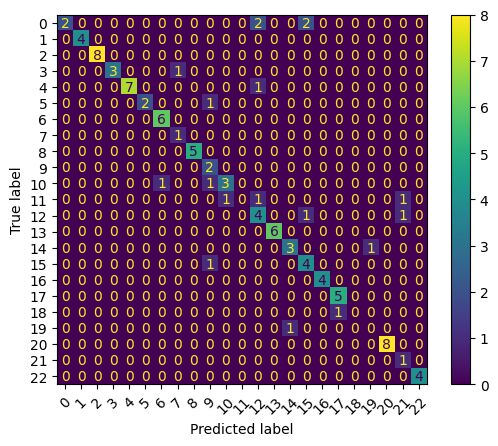

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs = trainer.predict(val_dataset)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = CLASSES
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [22]:
print(train_dataset.features)


{'NAME': Value(dtype='string', id=None), 'x1': Value(dtype='int64', id=None), 'y1': Value(dtype='int64', id=None), 'x2': Value(dtype='int64', id=None), 'y2': Value(dtype='int64', id=None), 'class': Value(dtype='string', id=None), 'class_enum': Value(dtype='int64', id=None), 'count': Value(dtype='int64', id=None), 'fold': Value(dtype='int64', id=None), 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

In [ ]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

loghistory = pd.DataFrame(trainer.state.log_history)
loghistory = loghistory.fillna(0)
loghistory = loghistory.groupby(['epoch']).sum()
fig, ax = plt.subplots(figsize=(6, 4))  # Set the size here (width, height)
loghistory[["eval_accuracy"]].plot(subplots=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Validation ACC'], loc='best')
plt.show()  # Display the plot

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels = outputs.label_ids
predictions = outputs.predictions

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.5f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# prompt: encerrar a execucao depois de 2 minutos deslogar do colab e terminar a execução

import os
import signal

# Function to handle the timeout
def timeout_handler(signum, frame):
    raise TimeoutError("Execution timed out")

# Set the timeout for 2 minutes (120 seconds)
signal.signal(signal.SIGALRM, timeout_handler)
signal.alarm(120)  # 120 seconds

try:
    # Your existing code goes here
    # ... (your entire code from the previous response) ...
except TimeoutError:
    print("Script execution timed out after 2 minutes.")
finally:
    # Code to execute regardless of timeout
    print("Exiting script...")
    os.kill(os.getpid(), signal.SIGTERM)  # Terminate the Colab runtime
